In [1]:
!pip install pyspark

In [2]:
import pyspark
from pyspark.sql.functions import monotonically_increasing_id 

from pyspark import SparkContext, SparkConf
import collections

from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time, random, re, requests

from numpy import dot
from numpy.linalg import norm
from scipy import spatial
from scipy.spatial.distance import cdist

 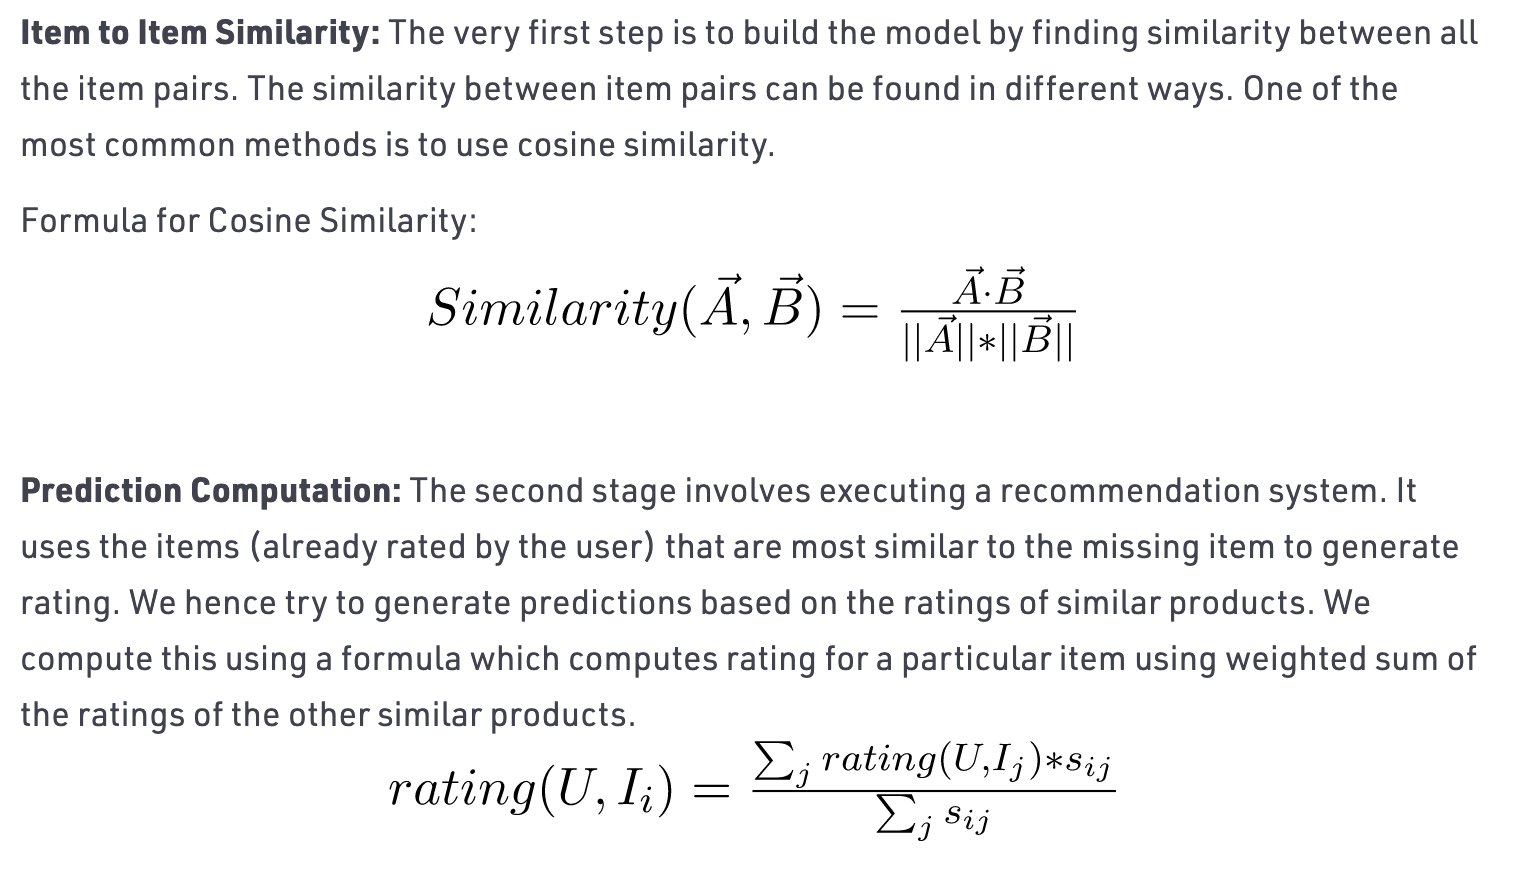

In [3]:
# No Pyspark
class IBCollaborativeFiltering:
  def __init__(self, rating, movie):
    self.rating = rating
    self.movie = movie
    self.user_merge_movie = pd.merge(self.rating, self.movie, on='movieId').iloc[:1000000]
    self.movie_matrix_with_index_userId = self.user_merge_movie.pivot_table(index=['userId'],columns=['title'],values=['rating'])["rating"]
    self.movie_matrix_with_index_title = self.user_merge_movie.pivot_table(index=['title'],columns=['userId'],values=['rating'])["rating"]
  def cosineSimilarity(self, list1, list2):
    rs1 = []
    rs2 = []
    for i in range(0, len(list1)):
      if str(list1[i]) != 'nan' and str(list2[i]) != 'nan':
        rs1.append(list1[i])
        rs2.append(list2[i])
    if len(rs1) > 0:
      return 1 - spatial.distance.cosine(rs1, rs2)
    else:
      return 0
  def itemSimilarity(self):
    movie_col = self.movie_matrix_with_index_title.copy().values.tolist()
    rs = []
    for i in movie_col:
      temp = []
      for j in movie_col:
        temp.append(self.cosineSimilarity(i, j))
      rs.append(temp)
    self.cosine_similarity_items = rs

  def predictionComputationForUser(self, list_row, index_col):
    numerator = 0
    denominator = 0
    for i in range(0, len(list_row)):
      if i != index_col and str(list_row[i]) != "nan":
        numerator += list_row[i] * self.cosine_similarity_items[index_col][i]
        denominator += self.cosine_similarity_items[index_col][i]
    return numerator/ denominator
  def recommendation(self):
    prediction_computation_tmp = self.movie_matrix_with_index_userId.copy()
    row, col = prediction_computation_tmp.shape
    for r in range(0, row):
      rs = prediction_computation_tmp.iloc[r,:].copy().values.tolist()
      for c in range(0, col):
        if str(rs[c]) == "nan":
          prediction_computation_tmp.iloc[r,c] = round(self.predictionComputationForUser(rs,c),5)
        else:
          prediction_computation_tmp.iloc[r,c] = -1
    self.prediction_computation_rating_new = prediction_computation_tmp
  def recommendationByUID(self, uID):
    list_title = self.movie_matrix_with_index_userId.columns.tolist()
    uid = self.movie_matrix_with_index_userId.index.tolist().index(uID)
    list_rating_new = self.prediction_computation_rating_new.iloc[uid,:].values.tolist()
    return sorted([[v,list_title[i]]  for i,v in enumerate(list_rating_new) if v > 0],key=lambda l:l[0], reverse=True)
    

In [4]:
# Pyspark
def cosine_similarity(list1, list2):
  rs1 = []
  rs2 = []
  for i in range(0, len(list1)):
    if str(list1[i]) != 'nan' and str(list2[i]) != 'nan':
      rs1.append(list1[i])
      rs2.append(list2[i])
  if len(rs1) > 0:
    return 1 - spatial.distance.cosine(rs1, rs2)
  else:
    return 0 

def prediction_computation_of_user(cosine_similarity_items, row_rating, index_i):
  numerator = 0
  denominator = 0
  for c in range(0,len(row_rating)):
    if str(row_rating[c]) != "nan" and index_i != c :
      numerator += row_rating[c] * cosine_similarity_items[index_i][c]
      denominator += cosine_similarity_items[index_i][c]
  return numerator / denominator

def itemToItemSimilarity(rdd_data_col, data_col):
    rdd_col = rdd_data_col.cartesian(rdd_data_col)
    rdd_col = rdd_col.map(lambda x: cosine_similarity(x[0], x[1]))
    rdd_col_split_by_len = sc.parallelize(rdd_col.collect(),len(data_col))
    return rdd_col_split_by_len.glom().collect()

def recommendation(cosine_similarity_items, rdd_data_row):
    return rdd_data_row.zipWithIndex().map(lambda x: (x[1], x[0],[ round(prediction_computation_of_user(cosine_similarity_items, x[0], i), 5)  if str(v) == 'nan' else -1 for i,v in enumerate(x[0]) ] )).collect()

def recommendationByUID(list_movie_name, list_uID, rating_new, uID): 
    uid = list_uID.index(uID)
    rdd_rating = sc.parallelize(rating_new)
    rdd_rating_with_movie = rdd_rating.map(lambda x: (x[0],  [[x[2][i], list_movie_name[i]] for i in range(0,len(list_movie_name))] ))
    rdd_sort = rdd_rating_with_movie.map(lambda x: [x[0],sorted(x[1], key=lambda l:l[0], reverse=True) ] )
    recommendationForUID = rdd_sort.filter(lambda x: x[0] == uid).map(lambda x: x[1]).collect()[0]
    recommendationForUID = sc.parallelize(recommendationForUID).filter(lambda x: x[0] > 0)
    return recommendationForUID.collect()


In [5]:
# Example
rating_demo = pd.DataFrame({"userId": [1,2,3,2,3,5,1,3,5], "movieId": [1,1,1,2,2,2,3,3,3], "rating": [2,5,3,2,3,2,3,1,2]})
movie_demo = pd.DataFrame({"movieId": [1,2,3], "title": ["Movie1", "Movie2", "Movie3"]})

In [6]:
recommendationengine = IBCollaborativeFiltering(rating_demo,movie_demo)
recommendationengine.movie_matrix_with_index_userId

title,Movie1,Movie2,Movie3
userId,,,
1,2.0,NaN,3.0
2,5.0,2.0,NaN
3,3.0,3.0,1.0
5,NaN,2.0,2.0


In [7]:
recommendationengine.itemSimilarity()
recommendationengine.cosine_similarity_items

[[1.0, 0.9037378388935388, 0.7893522173763263],
 [0.9037378388935388, 1.0, 0.8682431421244593],
 [0.7893522173763263, 0.8682431421244593, 1.0]]

In [8]:
recommendationengine.recommendation()
recommendationengine.prediction_computation_rating_new

title,Movie1,Movie2,Movie3
userId,,,
1,-1.0,2.48998,-1.00000
2,-1.0,-1.00000,3.42861
3,-1.0,-1.00000,-1.00000
5,2.0,-1.00000,-1.00000


In [9]:
recommendationengine.recommendationByUID(1)

[[2.48998, 'Movie2']]

In [10]:
# Load Data
from google.colab import  drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
movie = pd.read_csv('/content/drive/My Drive/Colab Notebooks/movie.csv').drop(['genres'], axis=1);
rating = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rating.csv').drop(['timestamp'], axis=1)

In [12]:
#Use Pyspark To Recommendation 
start = time.time()
conf = SparkConf().setMaster("local[*]").setAppName("movie_recommendations")
sc = SparkContext.getOrCreate(conf=conf)

user_merge_movie = pd.merge(rating, movie, on='movieId').iloc[:1000000]
movie_matrix_with_index_userId = user_merge_movie.pivot_table(index=['userId'],columns=['title'],values=['rating'])["rating"]
movie_matrix_with_index_title = user_merge_movie.pivot_table(index=['title'],columns=['userId'],values=['rating'])["rating"]

list_movie_name = movie_matrix_with_index_userId.columns.tolist()
data_row = movie_matrix_with_index_userId.values.tolist()
data_col = movie_matrix_with_index_title.values.tolist()
rdd_data_row = sc.parallelize(data_row)
rdd_data_col = sc.parallelize(data_col)

cosine_similarity_items = itemToItemSimilarity(rdd_data_col,data_col)
cosine_similarity_items


[[1.0,
  0.9686817441229824,
  0.9586135852043881,
  0.9468558989991758,
  0.9460198396047058,
  0.9205157656646511,
  0.9462428211652687,
  0.9236843938024734,
  0.9533330799260863,
  0.9389016324609839,
  0.9227373987638848,
  0.9560722342568736,
  0.9265970443019618,
  0.9592427252094529,
  0.9590297738944727,
  0.9667721424904249,
  0.9686817441229824,
  1.0,
  0.9677381606474603,
  0.9572704788146537,
  0.9625978048198908,
  0.9385592055855844,
  0.9529269627523826,
  0.9375912218562351,
  0.9651621370215967,
  0.9538386814126523,
  0.9366397483223923,
  0.9702706492653702,
  0.9406079629530631,
  0.9695441049585373,
  0.968621427073727,
  0.9723049801853335],
 [0.9586135852043881,
  0.9677381606474603,
  1.0,
  0.957825292123705,
  0.9512717383649872,
  0.922716574894518,
  0.9428521301867002,
  0.9365644513686259,
  0.9613298909102024,
  0.9470176356457695,
  0.9328653532455731,
  0.9679190043506042,
  0.9322902374302119,
  0.9672029216749954,
  0.9643272916251313,
  0.967222350

In [13]:
rating_new = recommendation(cosine_similarity_items, rdd_data_row)
rating_new


[(0,
  [3.5,
   4.0,
   3.5,
   4.0,
   4.0,
   3.0,
   4.0,
   3.5,
   4.0,
   4.0,
   3.5,
   4.0,
   3.5,
   3.5,
   3.5,
   3.5,
   4.0,
   4.0,
   4.5,
   3.5,
   4.0,
   3.5,
   3.5,
   4.0,
   3.5,
   4.0,
   4.5,
   3.5,
   3.5,
   3.5,
   3.5,
   3.5],
  [-1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1]),
 (1,
  [5.0,
   5.0,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   5.0,
   5.0,
   5.0,
   nan,
   nan,
   nan,
   nan],
  [-1,
   -1,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   5.0,
   -1,
   -1,
   -1,
   5.0,
   5.0,
   5.0,
   5.0]

In [21]:
recommendationByUID(list_movie_name, movie_matrix_with_index_userId.index.tolist(), rating_new, 138493)

[[4.41391, 'Escape to Witch Mountain (1975)'],
 [4.41166, 'Wizard of Oz, The (1939)'],
 [4.4116, 'Die Hard (1988)'],
 [4.41156, 'Blade Runner (1982)'],
 [4.41109, 'Seven (a.k.a. Se7en) (1995)'],
 [4.41098, '2001: A Space Odyssey (1968)'],
 [4.41028, 'Reservoir Dogs (1992)'],
 [4.4102, 'Shawshank Redemption, The (1994)'],
 [4.41003, 'City of Lost Children, The (Cité des enfants perdus, La) (1995)'],
 [4.41, 'Rumble in the Bronx (Hont faan kui) (1995)'],
 [4.40984, 'Rob Roy (1995)'],
 [4.40972, 'Platoon (1986)'],
 [4.40959, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'],
 [4.40943, 'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)'],
 [4.40941, 'Silence of the Lambs, The (1991)'],
 [4.40936, 'Fish Called Wanda, A (1988)'],
 [4.40935,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'],
 [4.40836, 'Usual Suspects, The (1995)'],
 [4.40633, 'Terminator 2: Judgment Day (1991)'],
 [4.40534, 'Dragonheart (1996)'],
 [4.40518, 'Clerks (1994)']]

In [15]:
end = time.time()
print(end - start)

170.01600575447083


In [16]:
#No Pyspark To Recommendation
start = time.time()
recommendationengine = IBCollaborativeFiltering(rating,movie)
recommendationengine.movie_matrix_with_index_userId

title,2001: A Space Odyssey (1968),Blade Runner (1982),"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Clerks (1994),Die Hard (1988),Dragonheart (1996),E.T. the Extra-Terrestrial (1982),Escape to Witch Mountain (1975),"Fish Called Wanda, A (1988)",Interview with the Vampire: The Vampire Chronicles (1994),Jumanji (1995),Léon: The Professional (a.k.a. The Professional) (Léon) (1994),"Mask, The (1994)",Monty Python and the Holy Grail (1975),Monty Python's Life of Brian (1979),One Flew Over the Cuckoo's Nest (1975),Platoon (1986),Pulp Fiction (1994),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Reservoir Dogs (1992),Rob Roy (1995),Rumble in the Bronx (Hont faan kui) (1995),Seven (a.k.a. Se7en) (1995),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Terminator 2: Judgment Day (1991),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Usual Suspects, The (1995)",What's Eating Gilbert Grape (1993),"Wizard of Oz, The (1939)"
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.5,4.0,3.5,4.0,4.0,3.0,4.0,3.5,4.0,4.0,3.5,4.0,3.5,3.5,3.5,3.5,4.0,4.0,4.5,3.5,4.0,3.5,3.5,4.0,3.5,4.0,4.5,3.5,3.5,3.5,3.5,3.5
2,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,NaN,NaN,NaN,NaN
3,5.0,5.0,NaN,5.0,NaN,NaN,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,5.0,5.0,5.0,5.0,4.0,4.0,5.0,3.0,4.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,5.0,NaN,3.0,NaN,3.0,5.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138489,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN
138490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,3.0,NaN


In [17]:
recommendationengine.itemSimilarity()
recommendationengine.cosine_similarity_items

[[1.0,
  0.9686817441229824,
  0.9586135852043881,
  0.9468558989991758,
  0.9460198396047058,
  0.9205157656646511,
  0.9462428211652687,
  0.9236843938024734,
  0.9533330799260863,
  0.9389016324609839,
  0.9227373987638848,
  0.9560722342568736,
  0.9265970443019618,
  0.9592427252094529,
  0.9590297738944727,
  0.9667721424904249,
  0.957898460932856,
  0.9581605188253626,
  0.9560819870437811,
  0.9595253019176666,
  0.9463909788497915,
  0.9371812094357959,
  0.9523919581235284,
  0.9538166473521341,
  0.9571070664866963,
  0.9546943557702838,
  0.9552421715826542,
  0.9476424831602966,
  0.9574157367549431,
  0.9572848381194926,
  0.9522591104590394,
  0.9531971536559886],
 [0.9686817441229824,
  1.0,
  0.9677381606474603,
  0.9572704788146537,
  0.9625978048198908,
  0.9385592055855844,
  0.9529269627523826,
  0.9375912218562351,
  0.9651621370215967,
  0.9538386814126523,
  0.9366397483223923,
  0.9702706492653702,
  0.9406079629530631,
  0.9695441049585373,
  0.96862142707372

In [18]:
recommendationengine.recommendation()
recommendationengine.prediction_computation_rating_new

title,2001: A Space Odyssey (1968),Blade Runner (1982),"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Clerks (1994),Die Hard (1988),Dragonheart (1996),E.T. the Extra-Terrestrial (1982),Escape to Witch Mountain (1975),"Fish Called Wanda, A (1988)",Interview with the Vampire: The Vampire Chronicles (1994),Jumanji (1995),Léon: The Professional (a.k.a. The Professional) (Léon) (1994),"Mask, The (1994)",Monty Python and the Holy Grail (1975),Monty Python's Life of Brian (1979),One Flew Over the Cuckoo's Nest (1975),Platoon (1986),Pulp Fiction (1994),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Reservoir Dogs (1992),Rob Roy (1995),Rumble in the Bronx (Hont faan kui) (1995),Seven (a.k.a. Se7en) (1995),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Terminator 2: Judgment Day (1991),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Usual Suspects, The (1995)",What's Eating Gilbert Grape (1993),"Wizard of Oz, The (1939)"
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000
2,-1.00000,-1.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,-1.00000,-1.00000,-1.00000,5.00000,5.00000,5.00000,5.00000
3,-1.00000,-1.00000,4.58806,-1.00000,4.58968,4.58945,-1.00000,4.58768,-1.00000,4.58869,4.58850,4.58887,4.58872,4.58866,4.58829,-1.00000,4.58891,4.58947,-1.00000,-1.00000,4.58877,4.58892,4.58918,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000
4,2.65844,2.65993,2.65450,2.66012,2.67052,2.67380,2.66794,2.66479,2.66292,2.66174,2.67077,2.66139,-1.00000,2.65970,2.65772,2.65952,2.66363,2.65815,2.66754,2.65943,2.66555,2.66954,2.65934,2.66406,2.66384,2.66760,2.66625,-1.00000,-1.00000,2.66065,2.65795,2.66481
5,4.54507,4.54493,4.54412,4.54414,-1.00000,4.53844,-1.00000,4.54064,-1.00000,4.54120,-1.00000,4.54436,-1.00000,-1.00000,-1.00000,4.54351,4.54364,4.54573,-1.00000,4.54395,4.54146,4.54156,4.54257,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,4.54365,4.54374,4.54338,4.54249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138488,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,-1.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,-1.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000
138489,4.39967,4.40001,-1.00000,4.40089,4.40199,4.40300,4.40237,4.40142,4.40088,4.40130,4.40211,4.40097,4.40168,4.40068,4.40061,-1.00000,4.40158,4.40062,4.40156,4.40080,4.40184,4.40131,4.40116,-1.00000,-1.00000,4.40153,4.40157,4.40169,4.40058,-1.00000,4.40104,4.40127
138490,4.25158,4.25244,4.25094,4.25126,4.25440,4.25322,4.25027,4.25154,4.25072,4.25310,4.25341,4.25252,4.25371,4.25188,4.25154,4.25009,4.25151,-1.00000,4.25347,4.25174,4.25255,4.25153,4.25435,4.25208,-1.00000,4.25302,4.25344,4.25497,-1.00000,4.25258,-1.00000,4.24911


In [19]:
recommendationengine.recommendationByUID(138493)

[[4.41192, 'City of Lost Children, The (Cité des enfants perdus, La) (1995)'],
 [4.41165, 'Blade Runner (1982)'],
 [4.41164, 'Reservoir Dogs (1992)'],
 [4.41156, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'],
 [4.41154, 'Clerks (1994)'],
 [4.41144, '2001: A Space Odyssey (1968)'],
 [4.4112, 'Fish Called Wanda, A (1988)'],
 [4.41116, 'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)'],
 [4.41078, 'Usual Suspects, The (1995)'],
 [4.41064, 'Seven (a.k.a. Se7en) (1995)'],
 [4.4105, 'Rumble in the Bronx (Hont faan kui) (1995)'],
 [4.41031, 'Platoon (1986)'],
 [4.41018, 'Terminator 2: Judgment Day (1991)'],
 [4.41001, 'Silence of the Lambs, The (1991)'],
 [4.40996,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'],
 [4.4099, 'Die Hard (1988)'],
 [4.40962, 'Shawshank Redemption, The (1994)'],
 [4.40952, 'Rob Roy (1995)'],
 [4.40841, 'Wizard of Oz, The (1939)'],
 [4.40833, 'Dragonheart (1996)'],
 [4.40785, 'Escape to Witch Mountain (1975)']]

In [20]:
end = time.time()
print(end - start)

504.22256875038147
